**Lab No:03**<br>
**Binary Classification with Neural Network**


**Obejctive** <br>
To  reproduce and extend the workflow using the circles_binary_classification.csv dataset and to build, train, evaluate and compare PyTorch ANNs to classify the circular data and report findings.

**Submitted By: Apil Maraseni (ACE079BCT012)

**Theory:**
Binary classification with neural networks is a supervised learning method used to classify data into two classes (0 or 1). The network consists of an input layer, hidden layers, and a single output neuron with a Sigmoid activation function that produces a probability between 0 and 1. A threshold (usually 0.5) is used to decide the final class.

During training, the model uses Binary Cross-Entropy loss and optimizes weights through backpropagation and gradient descent. Model performance is evaluated using metrics such as accuracy, precision, recall, and F1-score. Neural networks are effective for binary classification because they can capture complex nonlinear patterns in data.

Task to be performed:


1.Data retrieval and inspection

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("circles_binary_classification.csv")

# Display first 5 rows
print("First 5 rows of the dataset:")
print(df.head())

# Display statistical summary
print("\nStatistical Summary:")
print(df.describe())


First 5 rows of the dataset:
         X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0

Statistical Summary:
                X1           X2       label
count  1000.000000  1000.000000  1000.00000
mean     -0.000448    -0.000804     0.50000
std       0.639837     0.641156     0.50025
min      -1.059502    -1.067768     0.00000
25%      -0.619251    -0.612176     0.00000
50%       0.008762    -0.003949     0.50000
75%       0.621933     0.624822     1.00000
max       1.033712     1.036004     1.00000


2. Data cleaning and feature design.

In [2]:

import torch

df = pd.read_csv("circles_binary_classification.csv")

# Minimal cleaning
df = df.dropna()

# Feature and label
X = df[['X1', 'X2']].values
y = df['label'].values

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

print("X shape:", X_tensor.shape)
print("y shape:", y_tensor.shape)


X shape: torch.Size([1000, 2])
y shape: torch.Size([1000, 1])


3. Visualize data

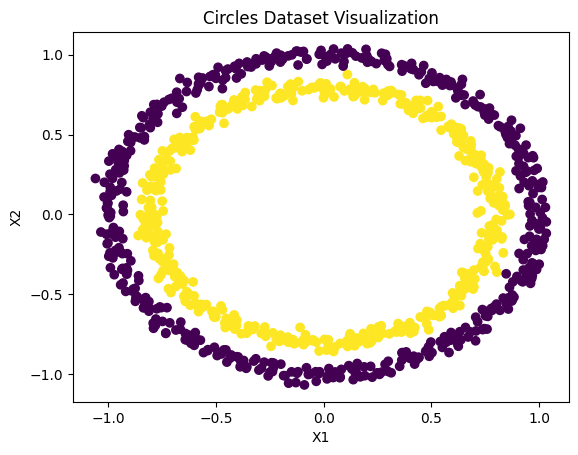

In [3]:
import matplotlib.pyplot as plt

plt.scatter(df['X1'], df['X2'], c=df['label'])
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Circles Dataset Visualization")
plt.show()


4. Train/test split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: torch.Size([800, 2])
X_test shape: torch.Size([200, 2])


5.Device and dtype

In [5]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move tensors to device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

print("Using device:", device)


Using device: cpu


6. Implement baseline models.

In [6]:
import torch.nn as nn

class ModelV0(nn.Module):

    def __init__(self):
        super().__init__()
        # 2. Create nn.Linear layers
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    # 3. Define forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

# 4. Create instance and move to device
model_0 = ModelV0().to(device)
model_0


ModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [8]:
class ModelV1(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 15)
        self.layer_2 = nn.Linear(15, 15)
        self.layer_3 = nn.Linear(15, 1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = ModelV1().to(device)
model_1


ModelV1(
  (layer_1): Linear(in_features=2, out_features=15, bias=True)
  (layer_2): Linear(in_features=15, out_features=15, bias=True)
  (layer_3): Linear(in_features=15, out_features=1, bias=True)
)

In [9]:
class ModelV2(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 64)
        self.layer_2 = nn.Linear(64, 64)
        self.layer_3 = nn.Linear(64, 10)
        self.layer_4 = nn.Linear(10, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        return self.layer_4(x)

model_2 = ModelV2().to(device)
model_2


ModelV2(
  (layer_1): Linear(in_features=2, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=10, bias=True)
  (layer_4): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

7. Loss, optimizer, metrices.

In [10]:

loss_fn = nn.BCEWithLogitsLoss()

optimizer_0 = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
optimizer_1 = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
optimizer_2 = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

def accuracy_fn(y_true, logits):
    y_pred = torch.round(torch.sigmoid(logits))
    return (y_pred.eq(y_true)).float().mean() * 100


8. Training loop

In [11]:

def train_and_test_loop(model, optimizer, X_train, y_train, X_test, y_test, epochs=100, print_every=10):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(1, epochs + 1):
        # ---- Train ----
        model.train()
        logits = model(X_train)
        loss = loss_fn(logits, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = accuracy_fn(y_train, logits)

        # ---- Eval ----
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test)
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_test, test_logits)

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        train_accs.append(acc.item())
        test_accs.append(test_acc.item())

        if epoch % print_every == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | "
                  f"Train Loss: {loss.item():.4f} | Train Acc: {acc.item():.2f}% | "
                  f"Test Loss: {test_loss.item():.4f} | Test Acc: {test_acc.item():.2f}%")

    return train_losses, test_losses, train_accs, test_accs


# -------- Experiments (reinitialize each time) --------

# V0 (~100 epochs)
model_0 = ModelV0().to(device)
optimizer_0 = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
v0_results = train_and_test_loop(model_0, optimizer_0, X_train, y_train, X_test, y_test, epochs=100, print_every=10)

# V1 (~1000 epochs)
model_1 = ModelV1().to(device)
optimizer_1 = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
v1_results = train_and_test_loop(model_1, optimizer_1, X_train, y_train, X_test, y_test, epochs=1000, print_every=10)

# V2 (~1000 epochs) (adjust between 100–1500)
model_2 = ModelV2().to(device)
optimizer_2 = torch.optim.SGD(params=model_2.parameters(), lr=0.1)
v2_results = train_and_test_loop(model_2, optimizer_2, X_train, y_train, X_test, y_test, epochs=1000, print_every=10)


Epoch    1 | Train Loss: 0.7066 | Train Acc: 50.00% | Test Loss: 0.7052 | Test Acc: 50.00%
Epoch   10 | Train Loss: 0.6996 | Train Acc: 50.00% | Test Loss: 0.6988 | Test Acc: 50.00%
Epoch   20 | Train Loss: 0.6960 | Train Acc: 50.00% | Test Loss: 0.6955 | Test Acc: 50.00%
Epoch   30 | Train Loss: 0.6945 | Train Acc: 50.00% | Test Loss: 0.6942 | Test Acc: 50.00%
Epoch   40 | Train Loss: 0.6938 | Train Acc: 43.88% | Test Loss: 0.6937 | Test Acc: 43.00%
Epoch   50 | Train Loss: 0.6935 | Train Acc: 46.88% | Test Loss: 0.6935 | Test Acc: 45.00%
Epoch   60 | Train Loss: 0.6934 | Train Acc: 49.00% | Test Loss: 0.6934 | Test Acc: 44.50%
Epoch   70 | Train Loss: 0.6933 | Train Acc: 49.62% | Test Loss: 0.6934 | Test Acc: 46.00%
Epoch   80 | Train Loss: 0.6932 | Train Acc: 50.00% | Test Loss: 0.6935 | Test Acc: 46.00%
Epoch   90 | Train Loss: 0.6932 | Train Acc: 49.50% | Test Loss: 0.6935 | Test Acc: 49.50%
Epoch  100 | Train Loss: 0.6931 | Train Acc: 49.62% | Test Loss: 0.6936 | Test Acc: 51.50%

9. Predictions and evalutaion.

In [12]:

def get_preds(model, X):
    model.eval()
    with torch.inference_mode():
        logits = model(X)
        probs = torch.sigmoid(logits)
        preds = torch.round(probs)
    return logits, probs, preds

# ---- Untrained predictions (example: V2) ----
model_untrained = ModelV2().to(device)
_, probs_u, preds_u = get_preds(model_untrained, X_test)
print("Untrained preds (first 10):", preds_u[:10].view(-1).detach().cpu().numpy().astype(int))
print("True labels    (first 10):", y_test[:10].view(-1).detach().cpu().numpy().astype(int))

# ---- Trained predictions (choose the trained model you want, e.g., model_2) ----
_, probs_t, preds_t = get_preds(model_2, X_test)
print("\nTrained preds   (first 10):", preds_t[:10].view(-1).detach().cpu().numpy().astype(int))
print("True labels     (first 10):", y_test[:10].view(-1).detach().cpu().numpy().astype(int))


Untrained preds (first 10): [0 0 0 0 1 1 0 1 0 0]
True labels    (first 10): [1 0 1 0 1 1 0 0 1 0]

Trained preds   (first 10): [1 0 1 0 1 1 0 0 1 0]
True labels     (first 10): [1 0 1 0 1 1 0 0 1 0]


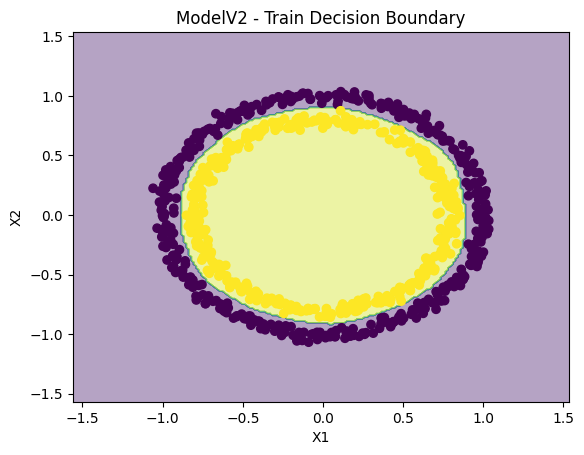

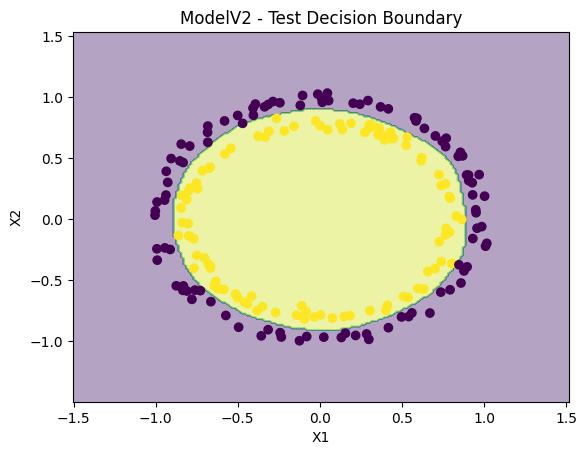

In [14]:
import numpy as np
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    X_cpu = X.detach().cpu().numpy()
    y_cpu = y.detach().cpu().numpy().reshape(-1)

    x_min, x_max = X_cpu[:, 0].min() - 0.5, X_cpu[:, 0].max() + 0.5
    y_min, y_max = X_cpu[:, 1].min() - 0.5, X_cpu[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_t = torch.tensor(grid, dtype=torch.float32).to(device)

    model.eval()
    with torch.inference_mode():
        logits = model(grid_t)
        preds = torch.round(torch.sigmoid(logits)).detach().cpu().numpy().reshape(xx.shape)

    plt.contourf(xx, yy, preds, alpha=0.4)
    plt.scatter(X_cpu[:, 0], X_cpu[:, 1], c=y_cpu)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title(title)
    plt.show()

# Train boundary
plot_decision_boundary(model_2, X_train, y_train, title="ModelV2 - Train Decision Boundary")

# Test boundary
plot_decision_boundary(model_2, X_test, y_test, title="ModelV2 - Test Decision Boundary")


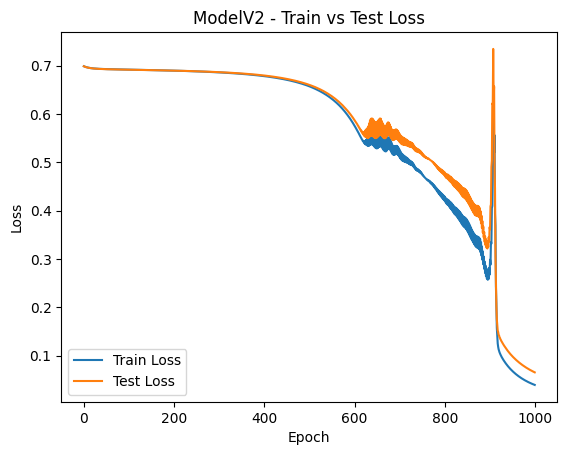

In [15]:
def plot_loss_curves(results, title="Loss Curves"):
    train_losses, test_losses, train_accs, test_accs = results

    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

# Example: for V2
plot_loss_curves(v2_results, title="ModelV2 - Train vs Test Loss")


Extra

In [16]:
import copy
import torch

def run_experiment(model_class, optimizer_name="sgd", lr=0.1, epochs=500, print_every=50):
    model = model_class().to(device)

    if optimizer_name.lower() == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name.lower() == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError("optimizer_name must be 'sgd' or 'adam'")

    results = train_and_test_loop(
        model=model,
        optimizer=optimizer,
        X_train=X_train, y_train=y_train,
        X_test=X_test, y_test=y_test,
        epochs=epochs,
        print_every=print_every
    )
    return model, results


# Use the same model architecture for fair comparison (recommended: ModelV2)
# SGD
sgd_model, sgd_results = run_experiment(ModelV2, optimizer_name="sgd", lr=0.1, epochs=500, print_every=50)

# Adam (usually use smaller lr)
adam_model, adam_results = run_experiment(ModelV2, optimizer_name="adam", lr=0.01, epochs=500, print_every=50)


Epoch    1 | Train Loss: 0.6983 | Train Acc: 50.00% | Test Loss: 0.6975 | Test Acc: 50.00%
Epoch   50 | Train Loss: 0.6919 | Train Acc: 50.00% | Test Loss: 0.6918 | Test Acc: 50.00%
Epoch  100 | Train Loss: 0.6896 | Train Acc: 65.62% | Test Loss: 0.6900 | Test Acc: 65.00%
Epoch  150 | Train Loss: 0.6867 | Train Acc: 78.00% | Test Loss: 0.6875 | Test Acc: 77.00%
Epoch  200 | Train Loss: 0.6823 | Train Acc: 82.00% | Test Loss: 0.6839 | Test Acc: 77.50%
Epoch  250 | Train Loss: 0.6751 | Train Acc: 91.50% | Test Loss: 0.6772 | Test Acc: 88.50%
Epoch  300 | Train Loss: 0.6613 | Train Acc: 96.75% | Test Loss: 0.6641 | Test Acc: 94.50%
Epoch  350 | Train Loss: 0.6331 | Train Acc: 98.62% | Test Loss: 0.6379 | Test Acc: 97.00%
Epoch  400 | Train Loss: 0.5653 | Train Acc: 99.00% | Test Loss: 0.5764 | Test Acc: 98.50%
Epoch  450 | Train Loss: 0.5513 | Train Acc: 57.38% | Test Loss: 0.5386 | Test Acc: 63.00%
Epoch  500 | Train Loss: 0.5075 | Train Acc: 62.00% | Test Loss: 0.5281 | Test Acc: 61.50%

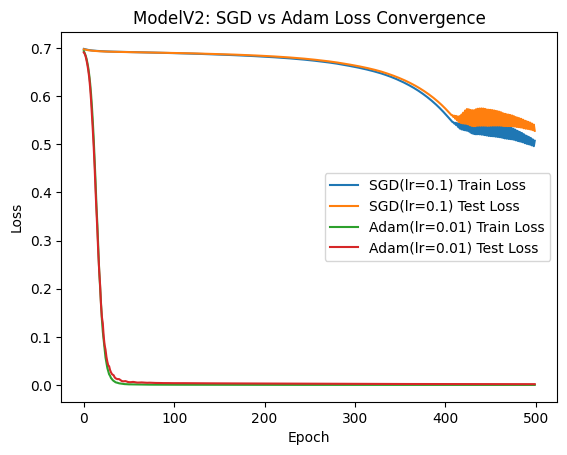

In [17]:
def plot_compare_loss(results_a, results_b, label_a="SGD", label_b="Adam", title="Convergence Comparison"):
    train_losses_a, test_losses_a, _, _ = results_a
    train_losses_b, test_losses_b, _, _ = results_b

    plt.plot(train_losses_a, label=f"{label_a} Train Loss")
    plt.plot(test_losses_a, label=f"{label_a} Test Loss")
    plt.plot(train_losses_b, label=f"{label_b} Train Loss")
    plt.plot(test_losses_b, label=f"{label_b} Test Loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

plot_compare_loss(sgd_results, adam_results, label_a="SGD(lr=0.1)", label_b="Adam(lr=0.01)",
                  title="ModelV2: SGD vs Adam Loss Convergence")


**Discussion**

In this assignment, a binary classification problem was solved using neural networks on the circles dataset. The data visualization confirmed that the classes form a circular pattern, which is not linearly separable. Baseline models without activation functions (ModelV0 and ModelV1) performed poorly because they behaved like linear classifiers and were unable to capture the non-linear decision boundary. In contrast, ModelV2, which included ReLU activation functions, successfully learned a non-linear boundary and achieved significantly higher accuracy. The training process also demonstrated the importance of optimizer choice, as Adam generally converged faster and more smoothly compared to SGD.

**Conclusion**

The implementation demonstrated the complete machine learning workflow for binary classification using neural networks. It highlighted the limitations of linear models on non-linear data and showed how activation functions enable neural networks to learn complex patterns. The comparison between optimizers further reinforced the impact of training strategies on convergence speed and performance. Overall, the assignment strengthened understanding of neural network architecture design, loss functions, optimization, and evaluation in binary classification tasks.